In [41]:
import warnings
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import timm

warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [42]:
def get_dataloaders(root='C:\\Users\\86135\\Downloads\\FER2013', bs=64, augment=True, for_saliency=False):
    mu, st = 0, 255  # Normalize grayscale [0,255] -> [0,1]

    # Used when generating saliency maps (no augmentation, no TenCrop)
    if for_saliency:
        basic_transform = transforms.Compose([
            transforms.Resize((48, 48)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((mu,), (st,))
        ])
        train_transform = test_transform = basic_transform

    else:
        test_transform = transforms.Compose([
            transforms.Resize((48, 48)),
            transforms.Grayscale(num_output_channels=1),
            transforms.TenCrop(40),
            transforms.Lambda(lambda crops: torch.stack([
                transforms.Normalize((mu,), (st,))(transforms.ToTensor()(crop)) for crop in crops
            ]))
        ])

        if augment:
            train_transform = transforms.Compose([
                transforms.Resize((48, 48)),
                transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.Grayscale(num_output_channels=1),
                transforms.TenCrop(40),
                transforms.Lambda(lambda crops: torch.stack([
                    transforms.Normalize((mu,), (st,))(transforms.ToTensor()(crop)) for crop in crops
                ]))
            ])
        else:
            train_transform = test_transform

    train_dataset = datasets.ImageFolder(root=f'{root}/train', transform=train_transform)
    test_dataset = datasets.ImageFolder(root=f'{root}/test', transform=test_transform)

    trainloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

    return trainloader, testloader

In [43]:
class VggFeatures(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        # print(x.shape)

        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))

        return x


class Vgg(VggFeatures):
    def __init__(self, drop=0.2):
        super().__init__(drop)
        self.lin3 = nn.Linear(4096, 7)

    def forward(self, x):
        x = super().forward(x)
        x = self.lin3(x)
        return x

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate your model
net = Vgg().to(device)

# Load the saved weights
state_dict = torch.load("best_vgg_fer2013.pth", map_location=device)

# Load weights into the model
net.load_state_dict(state_dict)

# Set to evaluation mode
net.eval()

Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

In [45]:
trainloader, testloader = get_dataloaders()
image, label = next(iter(trainloader))
image_plt = torch.squeeze(image)

# activate gradients for input/image
image = image.to(device)
image.requires_grad_()
print(image.requires_grad)

True


In [46]:
bs = image.shape[0]

if image.dim() == 5:  # [batch, n_crops, c, h, w]
    n_crops = image.shape[1]
    c, h, w = image.shape[2], image.shape[3], image.shape[4]
    # Flatten batch and crops into one batch dimension
    image = image.view(bs * n_crops, c, h, w)
else:
    n_crops = 1

# Enable gradient
image = image.clone().detach().requires_grad_(True)

# Forward pass
output = net(image)  # shape [bs*n_crops, num_classes]

if n_crops > 1:
    # Reshape to [bs, n_crops, num_classes]
    output = output.view(bs, n_crops, -1)
    # Average scores over crops
    output_avg = output.mean(dim=1)
else:
    output_avg = output

# Predicted class per sample
preds = output_avg.argmax(dim=1)

# Backpropagate score for first sample and its predicted class
score = output_avg[0, preds[0]]
score.backward()

if image.grad is None:
    print("Gradient not found. Check requires_grad and model connection.")
else:
    # image.grad shape: [bs*n_crops, c, h, w]
    if n_crops > 1:
        # Reshape grads back to [bs, n_crops, c, h, w]
        grads = image.grad.view(bs, n_crops, c, h, w)
        # Average grads over crops
        avg_grads = grads.mean(dim=1)  # [bs, c, h, w]
    else:
        avg_grads = image.grad

    saliency = avg_grads.abs().max(dim=1)[0]  # max over channels, [bs, h, w]

    saliency_img = saliency[0]

    # Normalize saliency map to [0,1]
    saliency_img -= saliency_img.min()
    saliency_img /= saliency_img.max()

    print("Prediction:", preds[0].item())


Prediction: 4


Image shape for plotting: torch.Size([40, 40])
Saliency map shape for plotting: (40, 40)


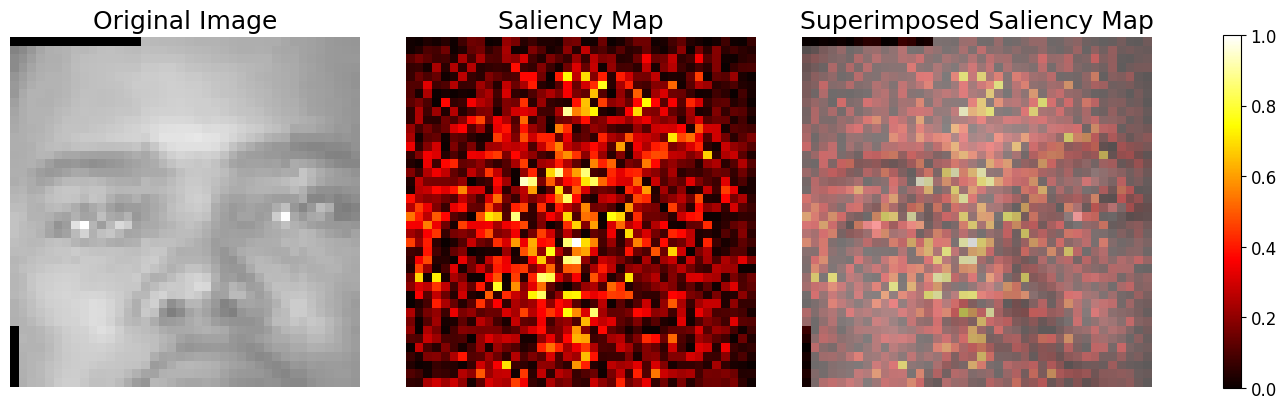

In [47]:
image_plt = image[0].detach().cpu()  # [C, H, W]

# If image has 1 channel, squeeze it out for 2D plotting
if image_plt.shape[0] == 1:
    image_plt = image_plt.squeeze(0)  # now [H, W]

# Saliency map shape check and conversion
saliency_map = saliency[0].detach().cpu().numpy()  # [channels, H, W]
if saliency_map.shape[0] == 1:
    saliency_map = saliency_map.squeeze(0)  # now [H, W]

print(f"Image shape for plotting: {image_plt.shape}")
print(f"Saliency map shape for plotting: {saliency_map.shape}")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.tight_layout()

# Plot 1: Original Image
axs[0].imshow(image_plt, cmap='gray')
axs[0].set_title('Original Image', fontsize=18)
axs[0].axis('off')

# Plot 2: Saliency Map (use a perceptually meaningful colormap)
im = axs[1].imshow(saliency_map, cmap='hot')
axs[1].set_title('Saliency Map', fontsize=18)
axs[1].axis('off')

# Plot 3: Superimposed
axs[2].imshow(image_plt, cmap='gray')
axs[2].imshow(saliency_map, cmap='hot', alpha=0.4)
axs[2].set_title('Superimposed Saliency Map', fontsize=18)
axs[2].axis('off')

# Shared colorbar for saliency
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.8)
cbar.ax.tick_params(labelsize=12)

plt.savefig("saliency.png", bbox_inches='tight')
plt.show()
